## AI Job Market Trends Analysis Project
#### For this project, I want to ask the following questions:
#####  1. What are the global AI job market trends in 2025?
#####  2. What are the key factors influencing AI job salaries?
#####  3. Which countries are leading in AI job opportunities and salaries?
#####  4. What are the emerging skills and technologies in the AI job market?
#####  5. What are the challenges and opportunities in the AI job market?
##### Dataset: /kaggle/input/global-ai-job-market-and-salary-trends-2025/ai_job_dataset.csv

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from itertools import combinations
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Part 1 - Data Preparation

In [4]:
df = pd.read_csv("ai_job_dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

In [6]:
print(df.shape)
print(df.columns)

(15000, 19)
Index(['job_id', 'job_title', 'salary_usd', 'salary_currency',
       'experience_level', 'employment_type', 'company_location',
       'company_size', 'employee_residence', 'remote_ratio', 'required_skills',
       'education_required', 'years_experience', 'industry', 'posting_date',
       'application_deadline', 'job_description_length', 'benefits_score',
       'company_name'],
      dtype='object')


In [7]:
df.describe()

salary_usd  remote_ratio  years_experience  job_description_length  \
count   15000.000000  15000.000000      15000.000000            15000.000000   
mean   115348.965133     49.483333          6.253200             1503.314733   
std     60260.940438     40.812712          5.545768              576.127083   
min     32519.000000      0.000000          0.000000              500.000000   
25%     70179.750000      0.000000          2.000000             1003.750000   
50%     99705.000000     50.000000          5.000000             1512.000000   
75%    146408.500000    100.000000         10.000000             2000.000000   
max    399095.000000    100.000000         19.000000             2499.000000   

       benefits_score  
count    15000.000000  
mean         7.504273  
std          1.450870  
min          5.000000  
25%          6.200000  
50%          7.500000  
75%          8.800000  
max         10.000000

### We found that all the columns in this dataset don't have null values, so we can proceed with the analysis.

### Part 2: Data Visualization

##### General Visualization

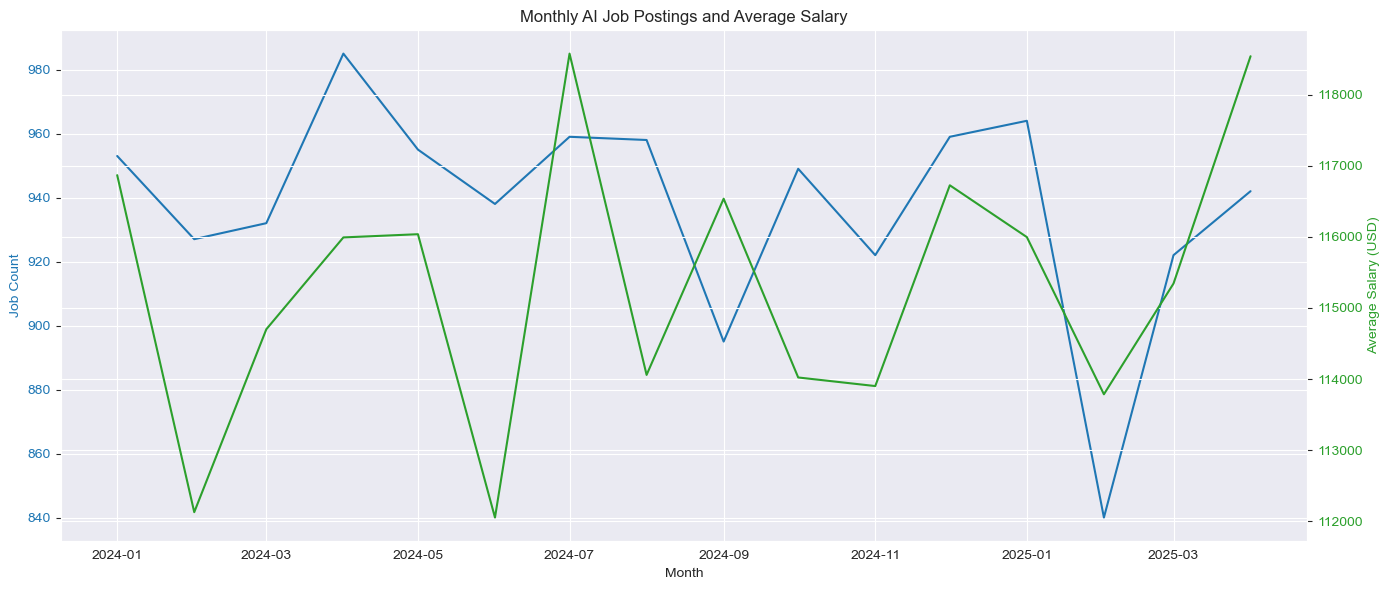

In [8]:
df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce")
df["month"] = df["posting_date"].dt.to_period("M")
monthly_count = df.groupby("month").size()
monthly_salary = df.groupby("month")["salary_usd"].mean()

fig, ax1 = plt.subplots(figsize=(14, 6))
color1 = 'tab:blue'
ax1.set_xlabel("Month")
ax1.set_ylabel("Job Count", color=color1)
ax1.plot(monthly_count.index.to_timestamp(), monthly_count.values, color=color1, label="Job Count")
ax1.tick_params(axis='y', labelcolor=color1)
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel("Average Salary (USD)", color=color2)
ax2.plot(monthly_salary.index.to_timestamp(), monthly_salary.values, color=color2, label="Avg Salary")
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Monthly AI Job Postings and Average Salary")
fig.tight_layout()
plt.show()

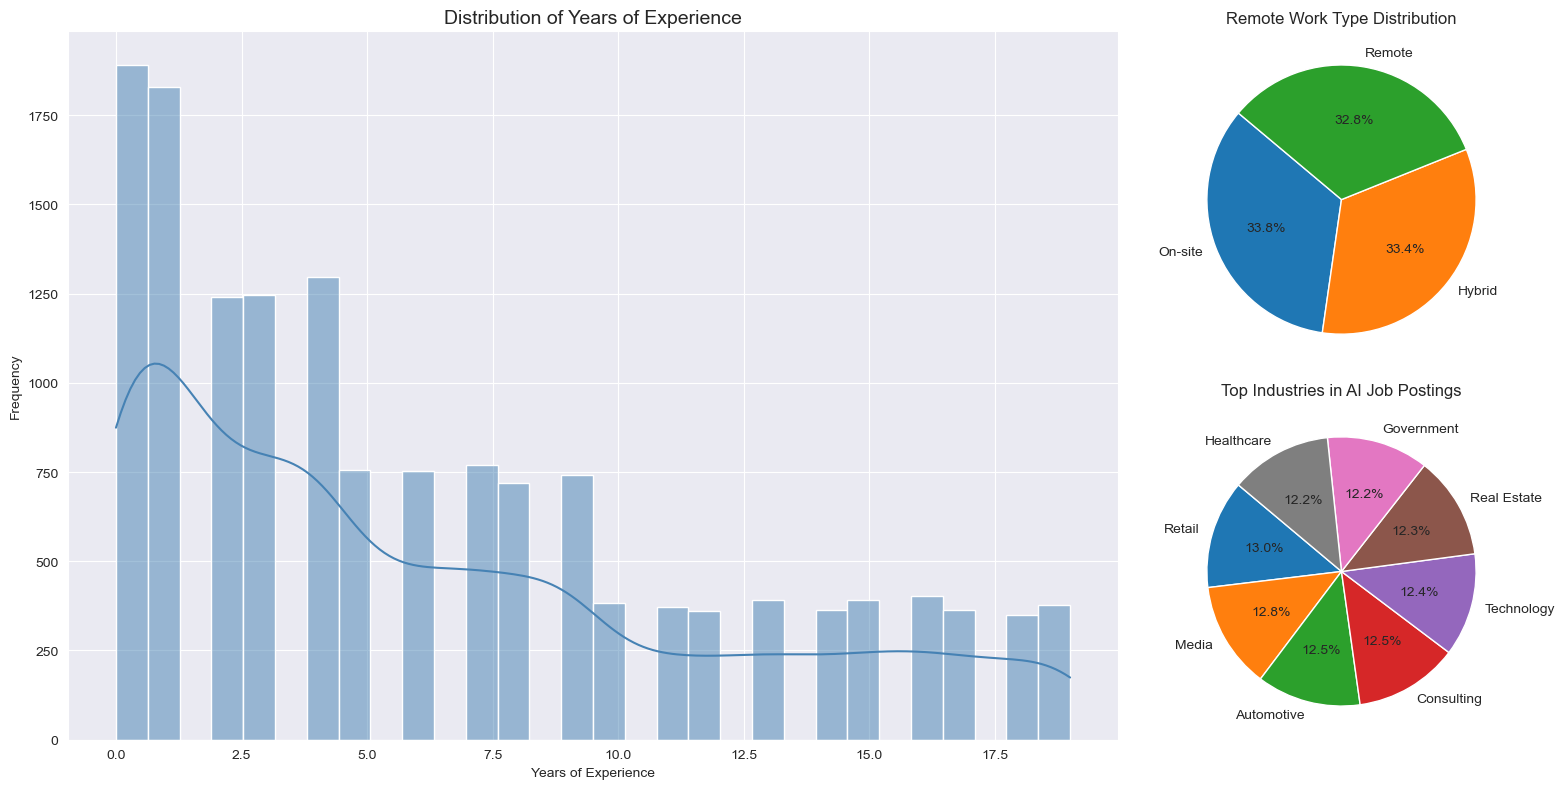

In [9]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1])

ax0 = plt.subplot(gs[:, 0])
sns.histplot(df["years_experience"].dropna(), bins=30, kde=True, ax=ax0, color="steelblue")
ax0.set_title("Distribution of Years of Experience", fontsize=14)
ax0.set_xlabel("Years of Experience")
ax0.set_ylabel("Frequency")
remote_labels = {0: "On-site", 50: "Hybrid", 100: "Remote"}
remote_counts = df["remote_ratio"].map(remote_labels).value_counts()
ax1 = plt.subplot(gs[0, 1])
ax1.pie(remote_counts, labels=remote_counts.index, autopct="%1.1f%%", startangle=140, textprops={'fontsize': 10})
ax1.set_title("Remote Work Type Distribution", fontsize=12)
industry_counts = df["industry"].value_counts().nlargest(8)
ax2 = plt.subplot(gs[1, 1])
ax2.pie(industry_counts, labels=industry_counts.index, autopct="%1.1f%%", startangle=140, textprops={'fontsize': 10})
ax2.set_title("Top Industries in AI Job Postings", fontsize=12)

plt.tight_layout()
plt.show()

##### Salary Visualization

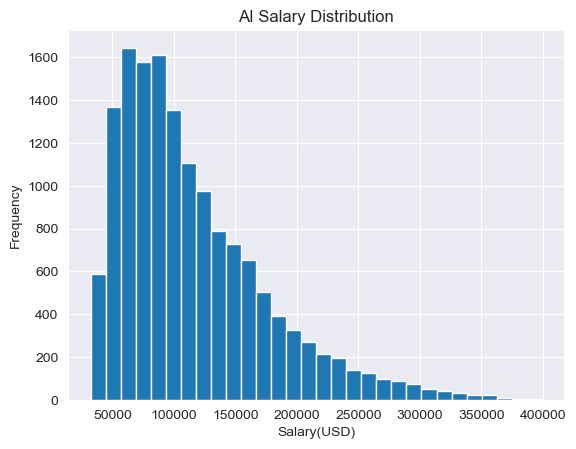

In [10]:
df['salary_usd'].dropna().plot.hist(bins=30, title='AI Salary Distribution')
plt.xlabel('Salary(USD)')
plt.savefig('salary_dist.png')

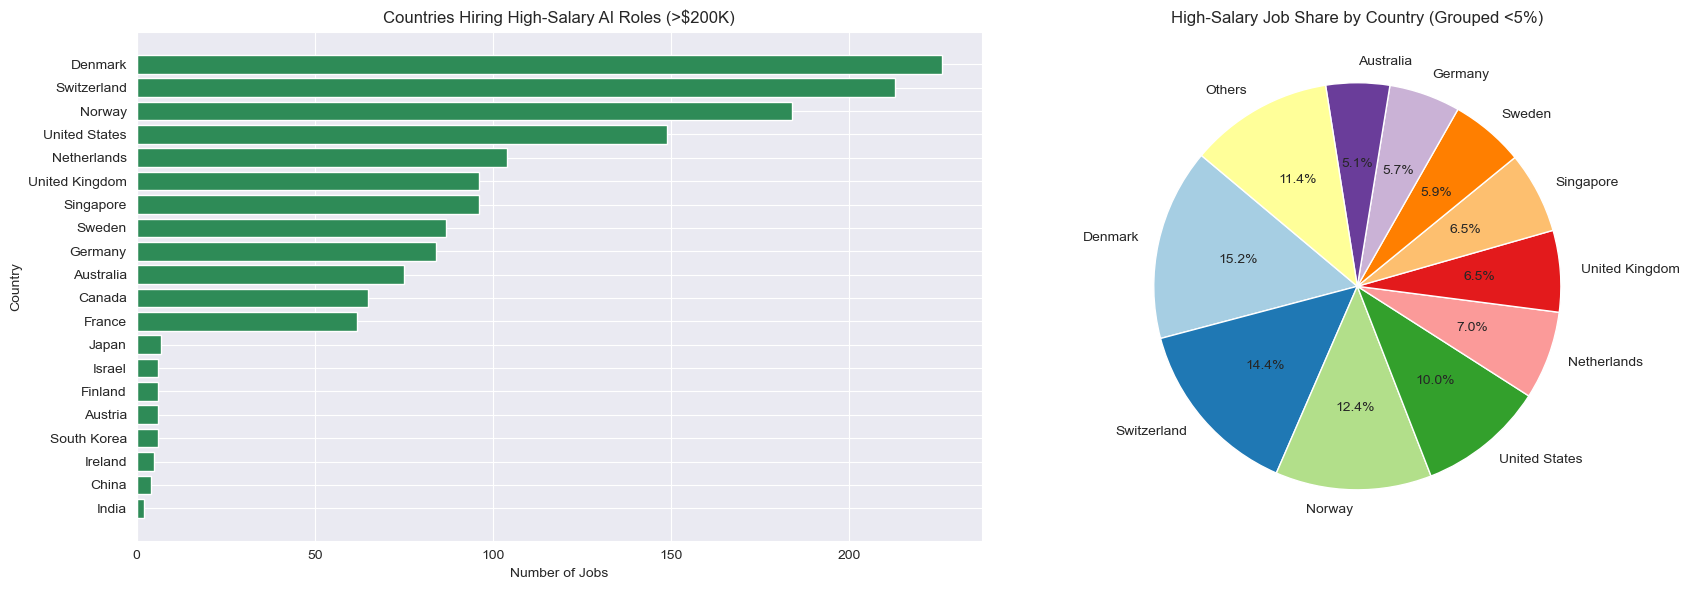

In [11]:
high_salary_df = df[df['salary_usd'] > 200000]
country_counts = high_salary_df['company_location'].value_counts()

total = country_counts.sum()
pie_data = country_counts[country_counts / total >= 0.05]
others = country_counts[country_counts / total < 0.05].sum()
pie_data["Others"] = others

bar_data = country_counts.sort_values(ascending=True)
fig, axes = plt.subplots(1, 2, figsize=(18, max(5, len(bar_data) * 0.3)))
axes[0].barh(bar_data.index, bar_data.values, color='seagreen')
axes[0].set_title("Countries Hiring High-Salary AI Roles (>$200K)")
axes[0].set_xlabel("Number of Jobs")
axes[0].set_ylabel("Country")

axes[1].pie(
    pie_data.values,
    labels=pie_data.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
axes[1].set_title("High-Salary Job Share by Country (Grouped <5%)")

plt.tight_layout()
plt.show()

In [12]:
map_data = country_counts.reset_index()
map_data.columns = ['company_location', 'count']

fig = px.choropleth(
    map_data,
    locations='company_location',
    locationmode='country names',
    color='count',
    color_continuous_scale='Viridis',
    title='Global Distribution of High-Salary AI Roles (>$200K)'
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title="Number of Jobs")
)

fig.show()

/var/folders/sp/86lyqnpx3hj4kmbg3ll3gyf80000gn/T/ipykernel_254/1361579003.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




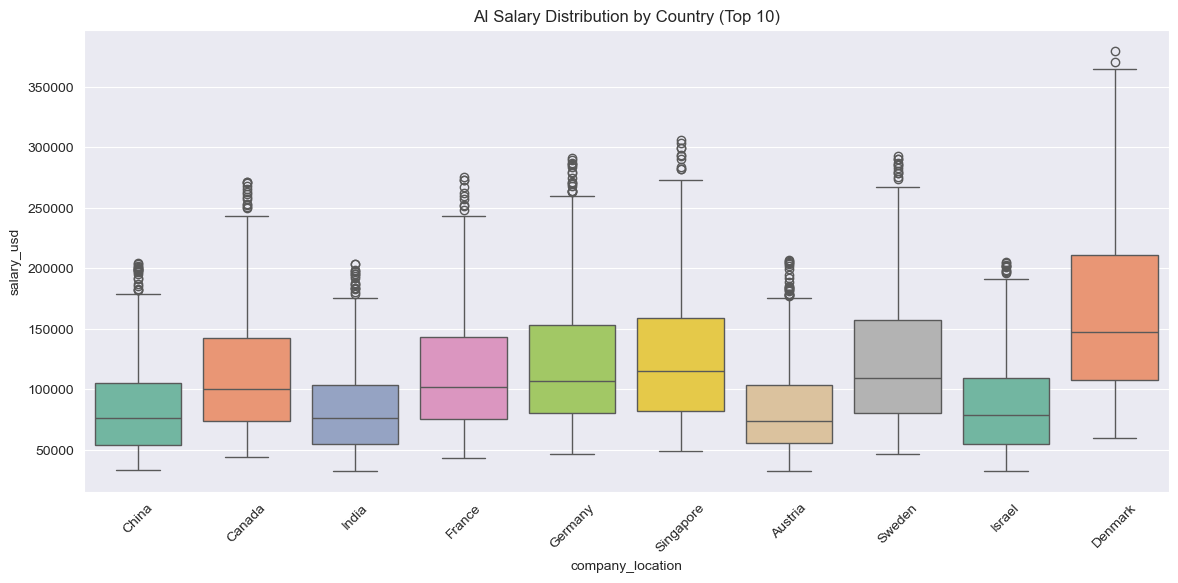

In [13]:
plt.figure(figsize=(14, 6))
top_countries = df['company_location'].value_counts().head(10).index
sns.boxplot(data=df[df['company_location'].isin(top_countries)],
            x='company_location', y='salary_usd', palette="Set2")
plt.title("AI Salary Distribution by Country (Top 10)")
plt.xticks(rotation=45)
plt.show()

##### Skills Visualization

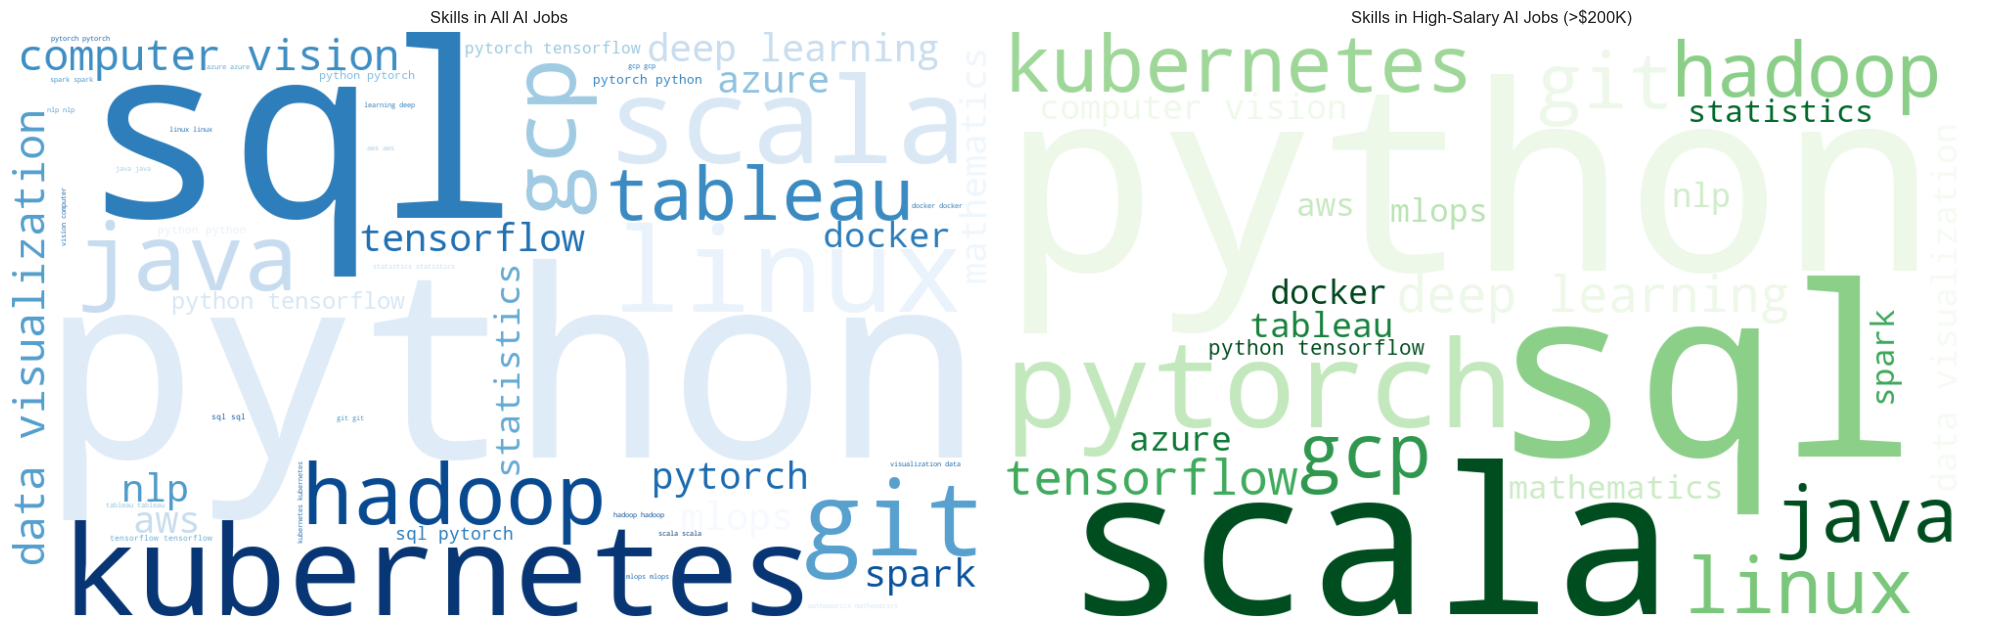

In [14]:
all_text = " ".join(df["required_skills"].dropna()).lower().replace(",", " ")
high_text = " ".join(high_salary_df["required_skills"].dropna()).lower().replace(",", " ")
wc_all = WordCloud(width=1000, height=600, background_color='white', colormap='Blues').generate(all_text)
wc_high = WordCloud(width=1000, height=600, background_color='white', colormap='Greens').generate(high_text)

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs[0].imshow(wc_all, interpolation='bilinear')
axs[0].axis("off")
axs[0].set_title("Skills in All AI Jobs")
axs[1].imshow(wc_high, interpolation='bilinear')
axs[1].axis("off")
axs[1].set_title("Skills in High-Salary AI Jobs (>$200K)")
plt.tight_layout()
plt.show()

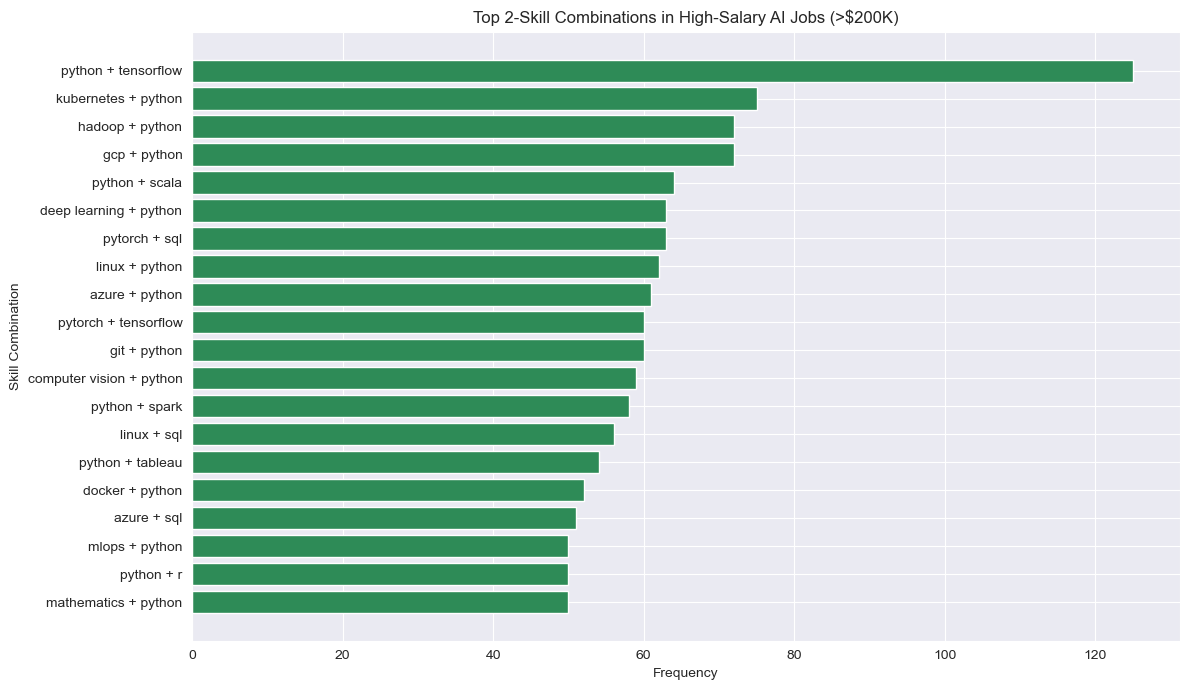

In [15]:
plt.show()
high_salary_skills = high_salary_df["required_skills"].dropna()
combo_counter = Counter()

for skills in high_salary_skills:
    skill_list = [s.strip().lower() for s in skills.split(",") if s.strip()]
    combos = combinations(sorted(set(skill_list)), 2)
    combo_counter.update(combos)

combo_df_2 = pd.DataFrame(combo_counter.items(), columns=["combo", "count"])
combo_df_2["combo"] = combo_df_2["combo"].apply(lambda x: " + ".join(x))
top_combos_2 = combo_df_2.sort_values("count", ascending=False).head(20)

plt.figure(figsize=(12, 7))
plt.barh(top_combos_2["combo"][::-1], top_combos_2["count"][::-1], color='seagreen')
plt.title("Top 2-Skill Combinations in High-Salary AI Jobs (>$200K)")
plt.xlabel("Frequency")
plt.ylabel("Skill Combination")
plt.tight_layout()
plt.show()

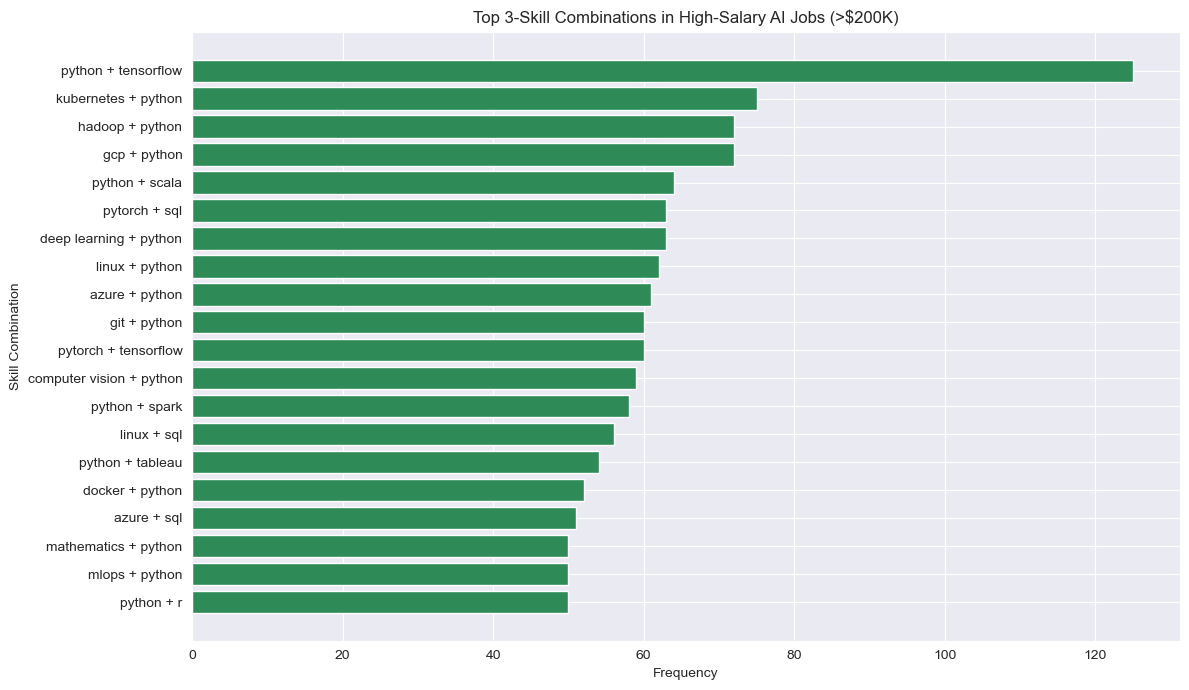

In [16]:
for skills in high_salary_skills:
    skill_list = [s.strip().lower() for s in skills.split(",") if s.strip()]
    combos = combinations(sorted(set(skill_list)), 3)
    combo_counter.update(combos)

combo_df_3 = pd.DataFrame(combo_counter.items(), columns=["combo", "count"])
combo_df_3["combo"] = combo_df_3["combo"].apply(lambda x: " + ".join(x))
top_combos_3 = combo_df_3.sort_values("count", ascending=False).head(20)

plt.figure(figsize=(12, 7))
plt.barh(top_combos_3["combo"][::-1], top_combos_3["count"][::-1], color='seagreen')
plt.title("Top 3-Skill Combinations in High-Salary AI Jobs (>$200K)")
plt.xlabel("Frequency")
plt.ylabel("Skill Combination")
plt.tight_layout()
plt.show()

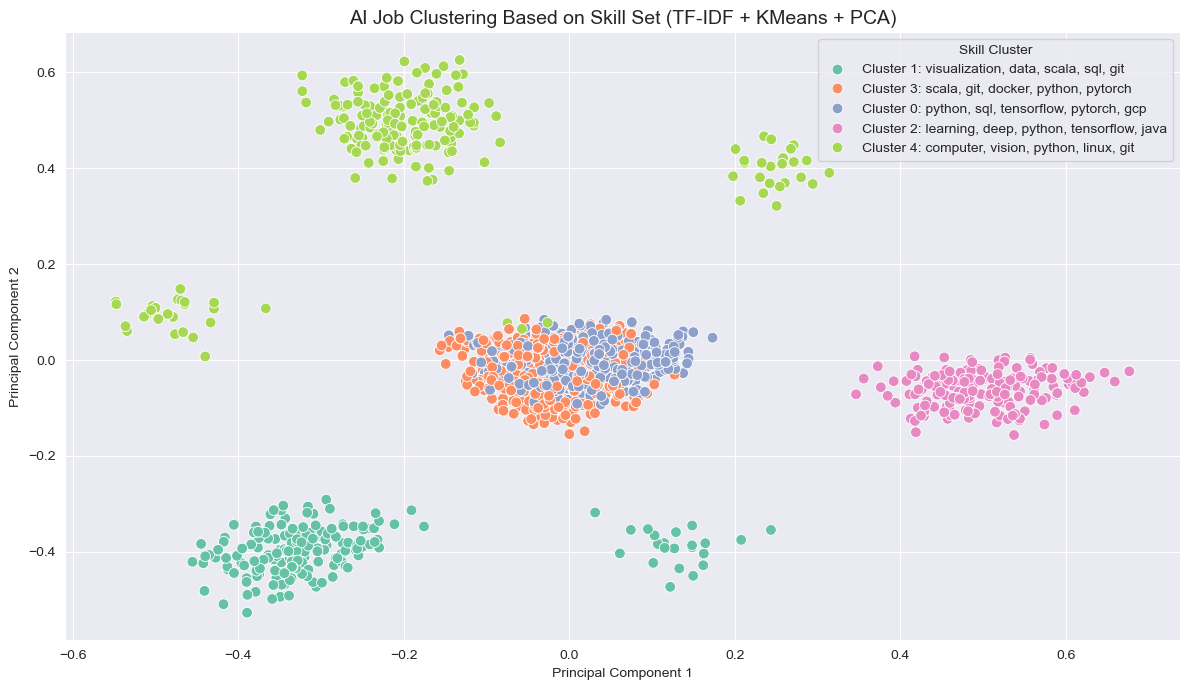

In [17]:
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words="english")
X = vectorizer.fit_transform(high_salary_skills)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

terms = vectorizer.get_feature_names_out()
cluster_labels = []
for i in range(k):
    center = kmeans.cluster_centers_[i]
    top_terms = np.argsort(center)[-5:][::-1]
    keywords = [terms[j] for j in top_terms]
    label = f"Cluster {i}: " + ", ".join(keywords)
    cluster_labels.append(label)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

cluster_name_map = {i: cluster_labels[i] for i in range(k)}
label_names = [cluster_name_map[c] for c in clusters]

plt.figure(figsize=(12, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=label_names, palette="Set2", s=60)
plt.title("AI Job Clustering Based on Skill Set (TF-IDF + KMeans + PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Skill Cluster", loc="best")
plt.tight_layout()
plt.show()

### Part 3: Predicting AI Job Salaries Using Random Forest

In [19]:
features = [
    'experience_level', 'employment_type', 'company_location',
    'company_size', 'employee_residence', 'remote_ratio',
    'education_required', 'years_experience', 'industry'
]

In [20]:
df_model = df[features + ['salary_usd']].dropna().copy()

categorical_cols = df_model.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

In [21]:
X = df_model[features]
y = df_model['salary_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/var/folders/sp/86lyqnpx3hj4kmbg3ll3gyf80000gn/T/ipykernel_254/1936650529.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sp/86lyqnpx3hj4kmbg3ll3gyf80000gn/T/ipykernel_254/1936650529.py:14: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.



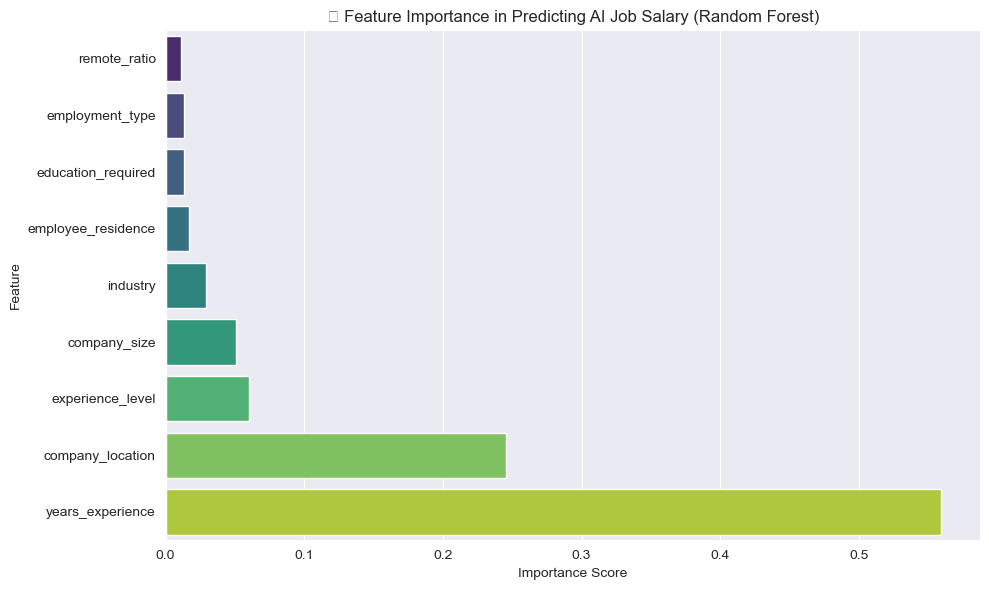

In [22]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("🔍 Feature Importance in Predicting AI Job Salary (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [23]:
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {rmse:.2f}")

R² Score: 0.8664
Mean Squared Error: 22230.29


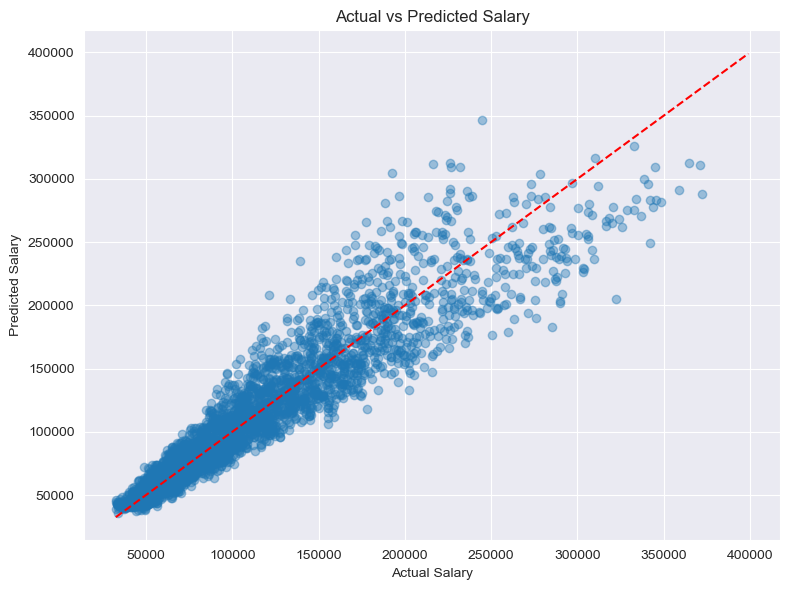

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.tight_layout()
plt.show()

In [25]:
sample = {
    'experience_level': 'SE',
    'employment_type': 'FT',
    'company_location': 'United States',
    'company_size': 'M',
    'employee_residence': 'United States',
    'remote_ratio': 100,
    'education_required': 'Master',
    'years_experience': 7,
    'industry': 'Technology'
}

sample_df = pd.DataFrame([sample])

for col in sample_df.columns:
    if col in label_encoders:
        sample_df[col] = label_encoders[col].transform(sample_df[col])

predicted_salary = rf.predict(sample_df)[0]
print(f"The predicted salary is（USD）: ${predicted_salary:,.0f}")

The predicted salary is（USD）: $154,212
